# Offshore Oil and Gas Energy System Operation (OOGESO) - example case
Representing a hypothetical, but realistic offshore oil and gas platform with production rates

* wellstream: 50 Sm3/s, of which:
    * gas: 49.75 Sm3/s = 4.3 mill Sm3/day = 4300 Sm3oe/day
    * oil:  0.1 Sm3/s = 8640 Sm3/day  
    * water: 0.15 Sm3/s = 12960 Sm3/day 

(Comparison with e.g. Oseberg Sør 2019: 3560 Sm3oe/day (oil), 2440 Sm3oe/day (gas)

Gas oil ratio and water cut (standard units):
* GOR = 4.3 mill/8640 = 497
* WC = 12960/(12960+8640) = 0.6


In [507]:
%load_ext autoreload
%autoreload 2
from oogeso import multicarrier
from oogeso import plots
import matplotlib.pyplot as plt
import IPython.display
import numpy as np
import pandas as pd
import logging
import pprint
import ipywidgets
import cloudpickle
import plotly.express as px
import pyomo.environ as pyo
#logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [508]:
#plots.plotGasTurbineEfficiency(filename='gasturbine.png')

## Read input data

_Configuration:_

In [523]:
case='1' # base case without wind
#case='1a' # case with 24 MW wind capacity
#case='1b' # case with 24 MW wind capacity AND 4 MW, 4 MWh battery
timerange=[0,12*24*7] #one week (with 5 min timestep)
#timerange=[0,40] # testing
outpath = "result_example2/"
pickle_save='{}case{}.pkl'.format(outpath,case)
plots.plotter="plotly"

In [524]:
mc = multicarrier.Multicarrier(loglevel=logging.INFO,quadraticConstraints=False)
data,profiles = multicarrier.read_data_from_xlsx("data_example2.xlsx")
#data['paramDeviceEnergyInitially'][17]=2.5 # MWh - battery
for dev in ['Gen1','Gen2','Gen3']:
    data['paramDeviceOnTimestepsInitially'][dev] = 10
    data['paramDeviceIsOnInitially'][dev] = 1
if case=='1':
    data['paramDevice']['wind']['Pmax']=0 # no wind
elif case=='1a':
    data['paramDevice']['wind']['Pmax']=8*3 # 3x8 MW, as agreed with ABB
elif case=='1b':
    data['paramDevice']['wind']['Pmax']=8*3 # 3x8 MW, as agreed with ABB
    data['paramDeviceEnergyInitially']['battery'] = data['paramDevice']['battery']['Emax']
    # and MANUALLY updating input XLSX file to include battery (include=1)


# fixed production - not allowed to reduce:
data['paramDevice']['wellL1']['Qmin'] = data['paramDevice']['wellL1']['Qmax']
data['paramDevice']['wellL2']['Qmin'] = data['paramDevice']['wellL2']['Qmax']

#data['paramParameters']['elReserveMargin'] = 4 #accept 4MW load loss
#data['paramParameters']['elReserveMargin'] = 0 #accept no load loss (100% backup)
#data['paramParameters']['elReserveMargin'] = -1 #skip constraint
#data['paramParameters']['elDispatchMargin'] = 5 #available unused power
    
instance = mc.createModelInstance(data,profiles)
#print("Writing instance to file.")
#instance.pprint(outpath+"problem_instance.txt")

2020-11-06 15:18:21 INFO: TODO: separator power (eta) and heat (eta2) demand
2020-11-06 15:18:21 INFO: TODO: gas turbine power vs heat output
2020-11-06 15:18:21 INFO: TODO: startup cost
2020-11-06 15:18:21 INFO: TODO: el source: dieselgen, fuel, on-off variables
2020-11-06 15:18:21 INFO: TODO: liquid pump approximation ok?
2020-11-06 15:18:21 INFO: TODO: startup delay does not work with Pmin>0
2020-11-06 15:18:21 INFO:       -use of prevHasBeenOn does not work as intended
2020-11-06 15:18:21 INFO: TODO: flow vs pressure equations for liquid flows
2020-11-06 15:18:21 INFO: TODO: pressure deviation limits per node
2020-11-06 15:18:21 INFO: TODO: Update Pmin constraint to allow GT startup delay
2020-11-06 15:18:32 INFO: Valid elBackupMargin not defined -> no constraint


In [20]:
xx=['','paramNode','paramEdge','paramDevice','paramCarriers','paramParameters','setProfile']
#xx=data.keys()
@ipywidgets.interact(datagroup=xx)
def showdata(datagroup):
    pprint.pprint(data[datagroup],width=1) if datagroup!='' else print('')

interactive(children=(Dropdown(description='datagroup', options=('', 'paramNode', 'paramEdge', 'paramDevice', …

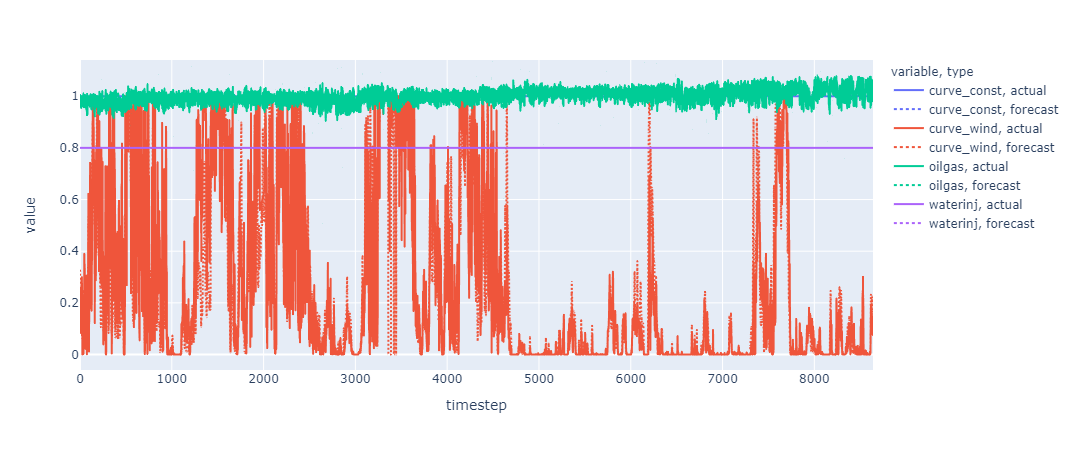

In [34]:
plots.plotProfiles(profiles,filename=None)

### Some checks on input data

In [12]:
print("flow per pipe = {:.4} Sm3/s".format(50/15))
flow1=multicarrier.Multicarrier.darcy_weissbach_Q(p1=6.164,p2=6,f=0.001,rho=5.63,
    diameter_mm=200,length_km=1,height_difference_m=100)
flow2=multicarrier.Multicarrier.darcy_weissbach_Q(p1=6.164,p2=4,f=0.0136,rho=5.63,
    diameter_mm=200,length_km=1,height_difference_m=100)
flow3=multicarrier.Multicarrier.darcy_weissbach_Q(p1=7,p2=4,f=0.0189,rho=5.63,
    diameter_mm=200,length_km=1,height_difference_m=100)
print("flow1 (6.164->6): {:.4}".format(flow1))
print("flow2 (6.164->4): {:.4}".format(flow2))
print("flow3 (7->4):     {:.4}".format(flow3))

flow per pipe = 3.333 Sm3/s
flow1 (6.164->6): 3.333
flow2 (6.164->4): 3.336
flow3 (7->4):     3.333


In [15]:
#transport-separator flow constraint seems ok
QQQ=50
print(6.00404116-(7- 1e-06*(1/15*QQQ-8.350301112430271)*2*997.1866725944546*119.41924718260051 - 1.0))
#wellstream pump:
#mc.compute_pump_demand(instance,'VSD_WST',Q=50,p1=6,p2=7,carrier="wellstream")
print("Pump power 6->6.146 MPa= {:.4} MW ({})".format(50*(6.164-6)/0.8,(6.164-6)/0.8))
print("Pump power 6->7 MPa    = {:4} MW ({})".format(50*(7-6)/0.8,(7-6)/0.8))

#print(mc.instance.paramNode['transport'])
#
#print("Pressure out={:.4} MPa".format(mc.compute_edge_pressuredrop(mc.instance,'c2',p1=6.164,Q=50/15,linear=False)))
#print(mc.instance.paramEdge['c2'])

-1.1908328150549856
Pump power 6->6.146 MPa= 10.25 MW (0.20499999999999963)
Pump power 6->7 MPa    = 62.5 MW (1.25)


In [16]:
# Water pipe pressure drop ('w3')
#mc.instance.paramEdge['w3']['num_pipes']=15
#mc.instance.paramEdge['w1']['diameter_mm']=200
print("Pressure out={:.4} MPa".format(mc.compute_edge_pressuredrop(mc.instance,'w1',p1=1.14,Q=1.15/3,linear=False)))
print(mc.instance.paramEdge['w1'])

Pressure out=0.6981 MPa
{'include': 1.0, 'nodeFrom': 'waterlift', 'nodeTo': 'pump_water', 'type': 'water', 'length_km': 0.01, 'diameter_mm': 200.0, 'height_m': 40.0, 'num_pipes': 3.0, 'pressure.from': 1.14, 'pressure.to': 0.7}


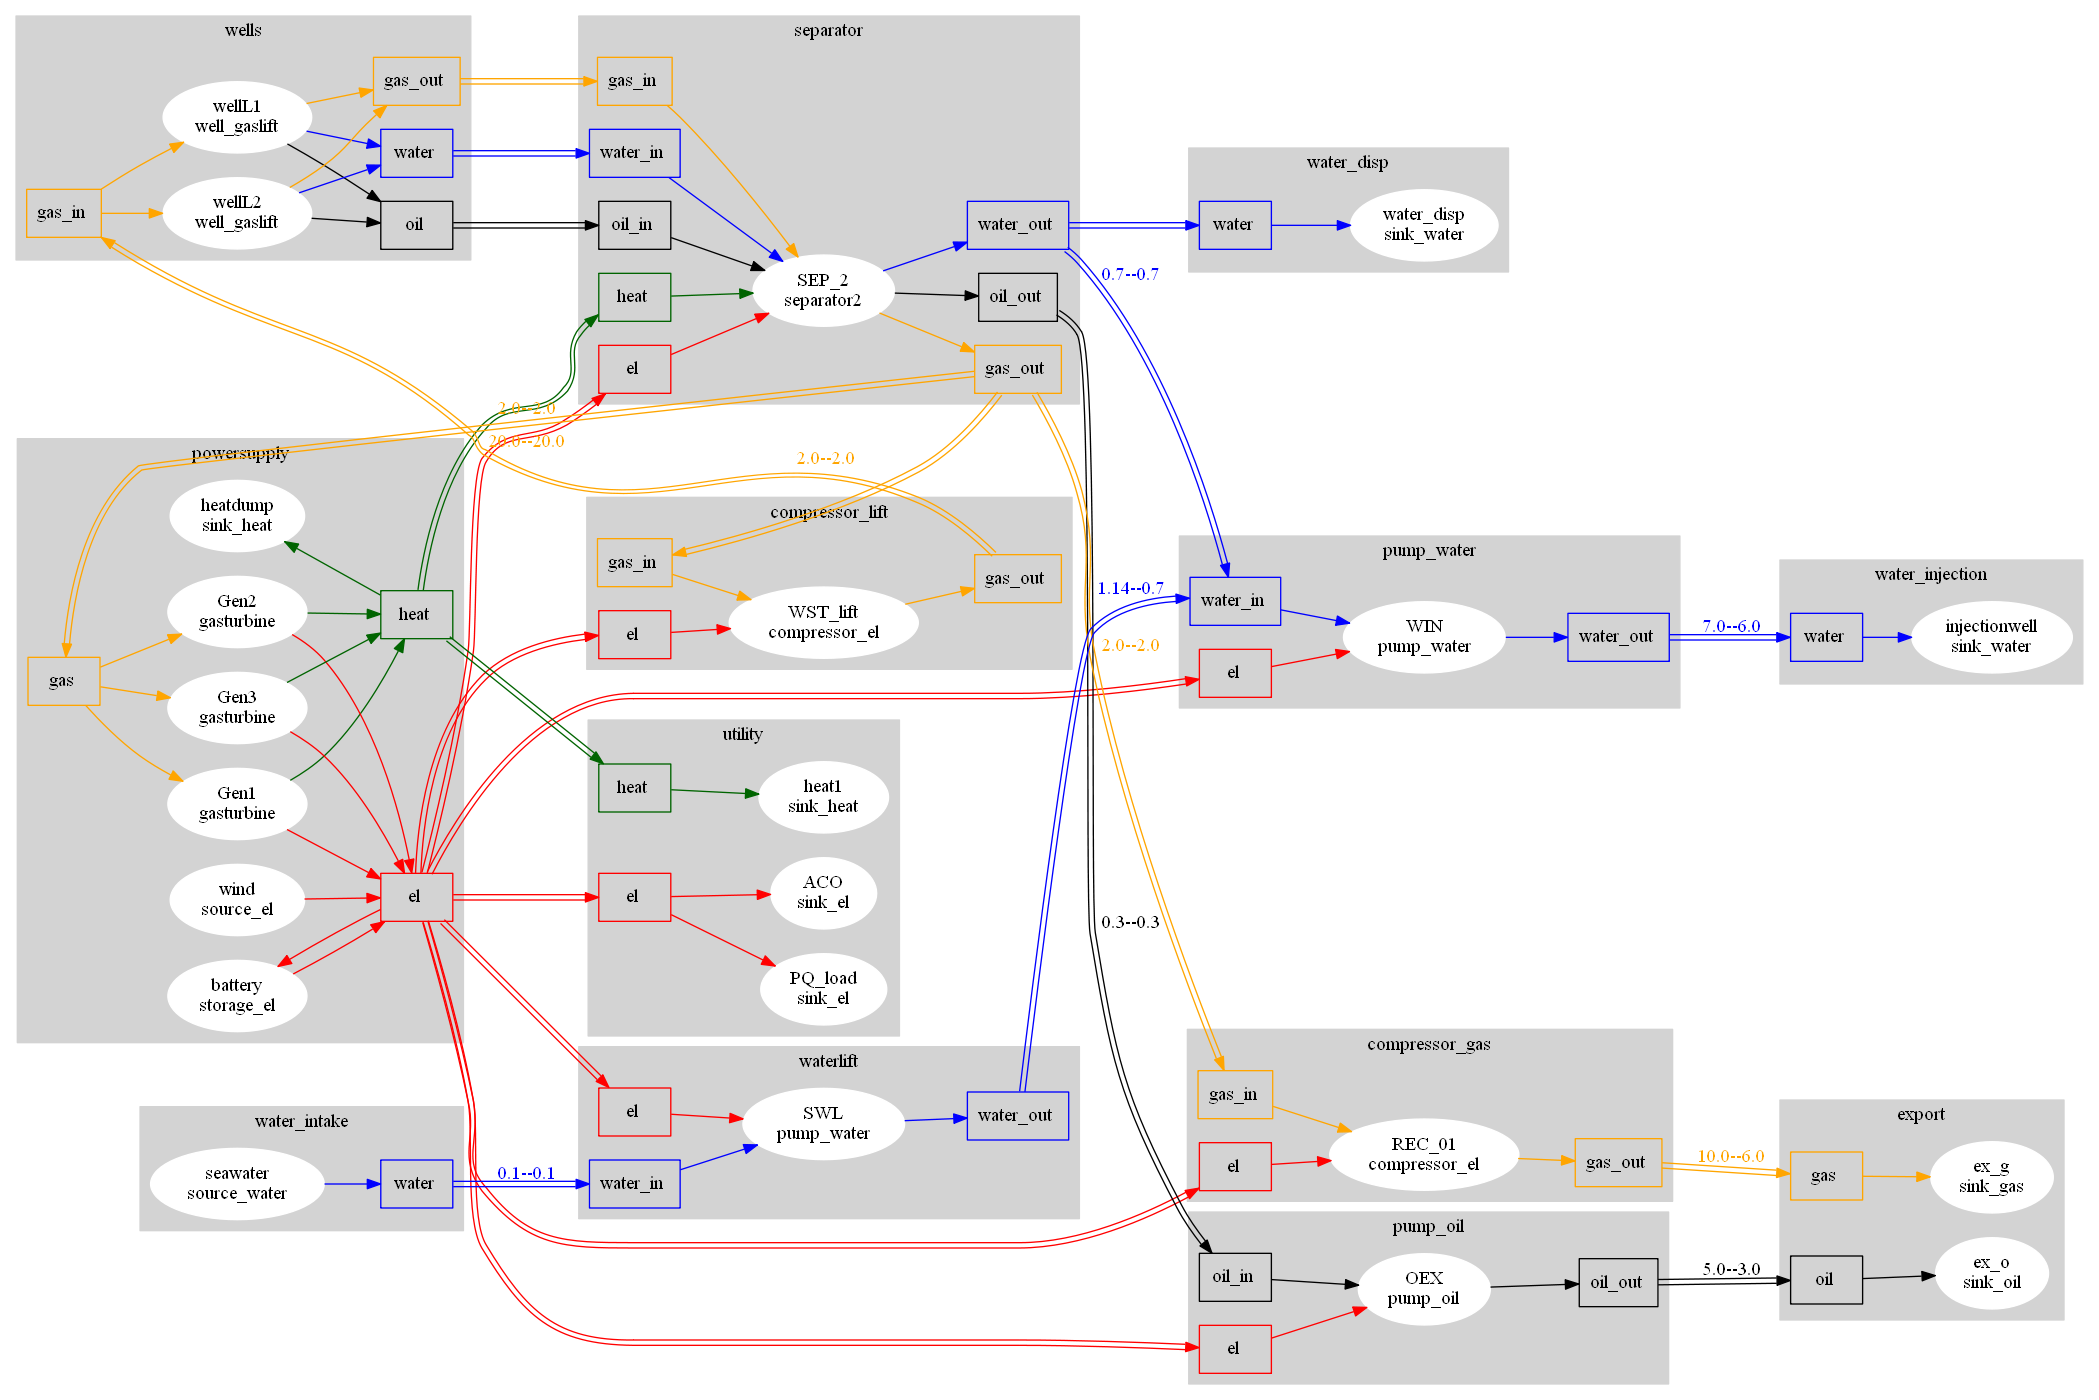

In [270]:
dotG=plots.plotNetwork(mc,timestep=None,filename=None)
#IPython.display.SVG(dotG.create_svg()) #original size, vector graphics
IPython.display.Image(dotG.create_png()) #scales automatically to page width

## Solve

If the problem is infeasible, try relaxing generic pressure deviation limits (input file "max_pressure_deviation")  
(Specify pressure deviation limit per node instead)
* Water injection Qmax restriction gives infeasible solution - WHY?? (adding el dump device doesn't help) Q changes from t=22 (low wind)
    * it seems to have to do with reserve capacity constraint

In [525]:
status = mc.solveMany(solver="cbc",timerange=timerange,write_yaml=False,timelimit=60)

sumCO2 = mc._dfCO2rate.mean()
co2intensity = mc._dfCO2intensity.mean()
exportrevenue = mc._dfExportRevenue.mean()
print("Mean CO2 emission rate      = {:.1f} kgCO2/s".format(sumCO2))
print("Mean CO2 emission intensity = {:.1f} kgCO2/Sm3oe".format(co2intensity))
print("Mean export revenue         =",*["{}:{:.1f} ".format(x,v) for x,v in mc._dfExportRevenue.mean().items() if v!=0],"$/s")

2020-11-06 15:18:32 INFO: Using solver timelimit=60
2020-11-06 15:18:32 INFO: Solving timestep=0
2020-11-06 15:18:33 INFO: Solving timestep=6
2020-11-06 15:18:35 INFO: Solving timestep=12
2020-11-06 15:18:36 INFO: Solving timestep=18
2020-11-06 15:18:37 INFO: Solving timestep=24
2020-11-06 15:18:40 INFO: Solving timestep=30
2020-11-06 15:18:42 INFO: Solving timestep=36
2020-11-06 15:18:43 INFO: Solving timestep=42
2020-11-06 15:18:44 INFO: Solving timestep=48
2020-11-06 15:18:46 INFO: Solving timestep=54
2020-11-06 15:18:47 INFO: Solving timestep=60
2020-11-06 15:18:49 INFO: Solving timestep=66
2020-11-06 15:18:51 INFO: Solving timestep=72
2020-11-06 15:18:52 INFO: Solving timestep=78
2020-11-06 15:18:54 INFO: Solving timestep=84
2020-11-06 15:18:55 INFO: Solving timestep=90
2020-11-06 15:18:56 INFO: Solving timestep=96
2020-11-06 15:18:58 INFO: Solving timestep=102
2020-11-06 15:18:59 INFO: Solving timestep=108
2020-11-06 15:19:01 INFO: Solving timestep=114
2020-11-06 15:19:03 INFO: S

Mean CO2 emission rate      = 7.6 kgCO2/s
Mean CO2 emission intensity = 53.1 kgCO2/Sm3oe
Mean export revenue         = oil:41.1  gas:19.2  $/s


In [526]:
#print(mc.instance.varDeviceFlow[('gasheater','gas','in',0)])
#mc.instance.constrDevice_ramprate.pprint()
#data['paramEdge']['c2']
#mc.instance.paramDevice['Gen1']
#instance.paramDevice.pprint()
#constr=mc.instance.constrEdgeFlowEquations['c2',0]
#print(constr.lower(),constr.upper())
#constr.pprint()
#mc.instance.constrEdgeFlowEquations.pprint("constrEdgeFlow.txt")
#mc.instance.paramNode.pprint()
#print("pressure deviation:",(9.93-10)/10,(5.27-5)/5,(6.16-6.164)/6.164, (6.53-7)/7)

In [527]:
#mc.instance.write("model.mps",io_options = {"symbolic_solver_labels":True})

## Compute KPIs

In [528]:
hour_per_year=8760
sec_per_year=3600*hour_per_year
kpi = {}

num_sim_timesteps=mc._dfCO2rate.shape[0]
timesteps=mc._dfCO2rate.index
kpi['hours_simulated'] = num_sim_timesteps*mc.instance.paramParameters['time_delta_minutes']/60

# CO2 emissions
kpi['kgCO2_per_year'] = mc._dfCO2rate.mean()*sec_per_year
kpi['kgCO2_per_Sm3oe'] = mc._dfCO2intensity.mean()

# hours with reduced load
kpi['reducedload_hours_per_year'] = None

# hours with load shedding
kpi['loadshed_hours_per_year'] = None

# fuel consumption
gasturbines = [i for i,g in mc.instance.paramDevice.items() if g['model']=='gasturbine']
mask_gt=mc._dfDeviceFlow.index.get_level_values('device').isin(gasturbines)
gtflow = mc._dfDeviceFlow[mask_gt]
fuel = gtflow.unstack('carrier')['gas'].unstack('terminal')['in'].unstack().mean(axis=1)
kpi['gt_fuel_sm3_per_year'] = fuel.sum()*sec_per_year

# electric power consumption
el_dem=mc._dfDeviceFlow.unstack('carrier')['el'].unstack('terminal')['in'].dropna().unstack().mean(axis=1)
kpi['elconsumption_mwh_per_year'] = el_dem.sum()*hour_per_year


# number of generator starts
gt_starts = mc._dfDeviceStarting.unstack().sum(axis=1)[gasturbines].sum()
kpi['gt_starts_per_year'] = gt_starts*hour_per_year/kpi['hours_simulated']

# number of generator stops
gt_stops = mc._dfDeviceStopping.unstack().sum(axis=1)[gasturbines].sum()
kpi['gt_stops_per_year'] = gt_stops*hour_per_year/kpi['hours_simulated']

# running hours of generators
gt_ison = mc._dfDeviceIsOn.unstack().sum(axis=1)[gasturbines].sum()
kpi['gt_hoursrunning_per_year'] = gt_ison*hour_per_year/kpi['hours_simulated']

# wind power output 
windturbines = ['wind']
el_sup=mc._dfDeviceFlow.unstack('carrier')['el'].unstack('terminal')['out'].dropna().unstack()
p_wind = el_sup.T[windturbines]
kpi['wind_output_mwh_per_year'] = p_wind.sum(axis=1).mean()*hour_per_year

# curtailed wind energy
p_avail = pd.DataFrame(index=timesteps)
for d in windturbines:
    devparam=mc.instance.paramDevice[d]
    Pmax = devparam['Pmax']
    p_avail[d] = Pmax
    if 'profile' in devparam:
        profile_ref = devparam['profile']
        p_avail[d] = Pmax * mc._df_profiles_actual.loc[timesteps,profile_ref]
p_curtailed = (p_avail - p_wind).sum(axis=1)
kpi['wind_curtailed_mwh_per_year'] = p_curtailed.mean()*hour_per_year

mc.kpi = kpi
kpi

{'hours_simulated': 168.0,
 'kgCO2_per_year': 241178232.99732703,
 'kgCO2_per_Sm3oe': 53.1161011060139,
 'reducedload_hours_per_year': None,
 'loadshed_hours_per_year': None,
 'gt_fuel_sm3_per_year': 103067620.93902674,
 'elconsumption_mwh_per_year': 357941.0221998721,
 'gt_starts_per_year': 0.0,
 'gt_stops_per_year': 0.0,
 'gt_hoursrunning_per_year': 315360.0,
 'wind_output_mwh_per_year': 0.0,
 'wind_curtailed_mwh_per_year': 0.0}

In [275]:
kpi

{'hours_simulated': 168.0,
 'kgCO2_per_year': 181357835.05755296,
 'kgCO2_per_Sm3oe': 39.751448054972606,
 'reducedload_hours_per_year': None,
 'loadshed_hours_per_year': None,
 'gt_fuel_sm3_per_year': 77503348.3151932,
 'elconsumption_mwh_per_year': 360658.6550065388,
 'gt_starts_per_year': 1147.142857142857,
 'gt_stops_per_year': 1199.2857142857142,
 'gt_hoursrunning_per_year': 233495.7142857143,
 'wind_output_mwh_per_year': 92780.85485858684,
 'wind_curtailed_mwh_per_year': 0.0003855541144966642}

## Save/Load simulation results

In [530]:
pickle_save

'result_example2/case1.pkl'

In [531]:
# Save (pickle) - for later opening and analysis
with open(pickle_save, mode='wb') as file:
   cloudpickle.dump(mc, file)

In [153]:
# Open previously saved object (including simulation results)
with open(pickle_save, mode='rb') as file:
   mc_loaded = cloudpickle.load(file)

In [532]:
with open(outpath+'case1.pkl', mode='rb') as file:
   mc_1 = cloudpickle.load(file)
with open(outpath+'case1a.pkl', mode='rb') as file:
   mc_1a = cloudpickle.load(file)
with open(outpath+'case1b.pkl', mode='rb') as file:
   mc_1b = cloudpickle.load(file)

## Analyse results

In [504]:
df_kpi=pd.DataFrame()
df_kpi=pd.concat([
    pd.DataFrame.from_dict(mc_1.kpi,orient="index",columns=['1']),
    pd.DataFrame.from_dict(mc_1a.kpi,orient="index",columns=['1a']),
    pd.DataFrame.from_dict(mc_1b.kpi,orient="index",columns=['1b'])
],axis=1)
print("Difference from base case\n---------------------------------abs------------rel------")
for i,r in df_kpi.iterrows():
    print("{:30}: {:12.6g}    {:10.6g}".format(i,r['1a']-r['1'],r['1a']/r['1']))
#(df_kpi['1a']-df_kpi['1'])

Difference from base case
---------------------------------abs------------rel------
hours_simulated               :            0             1
kgCO2_per_year                : -5.98204e+07      0.751966
kgCO2_per_Sm3oe               :     -13.3647      0.748388
reducedload_hours_per_year    :          nan           nan
loadshed_hours_per_year       :          nan           nan
gt_fuel_sm3_per_year          : -2.55643e+07      0.751966
elconsumption_mwh_per_year    :      2717.63       1.00759
gt_starts_per_year            :      1147.14           inf
gt_stops_per_year             :      1199.29           inf
gt_hoursrunning_per_year      :     -81864.3       0.74041
wind_output_mwh_per_year      :      92780.9           inf
wind_curtailed_mwh_per_year   :  0.000385554           inf


C:\Users\hsven\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning:

divide by zero encountered in double_scalars



In [505]:
df_kpi.to_csv(outpath+"kpis.csv")

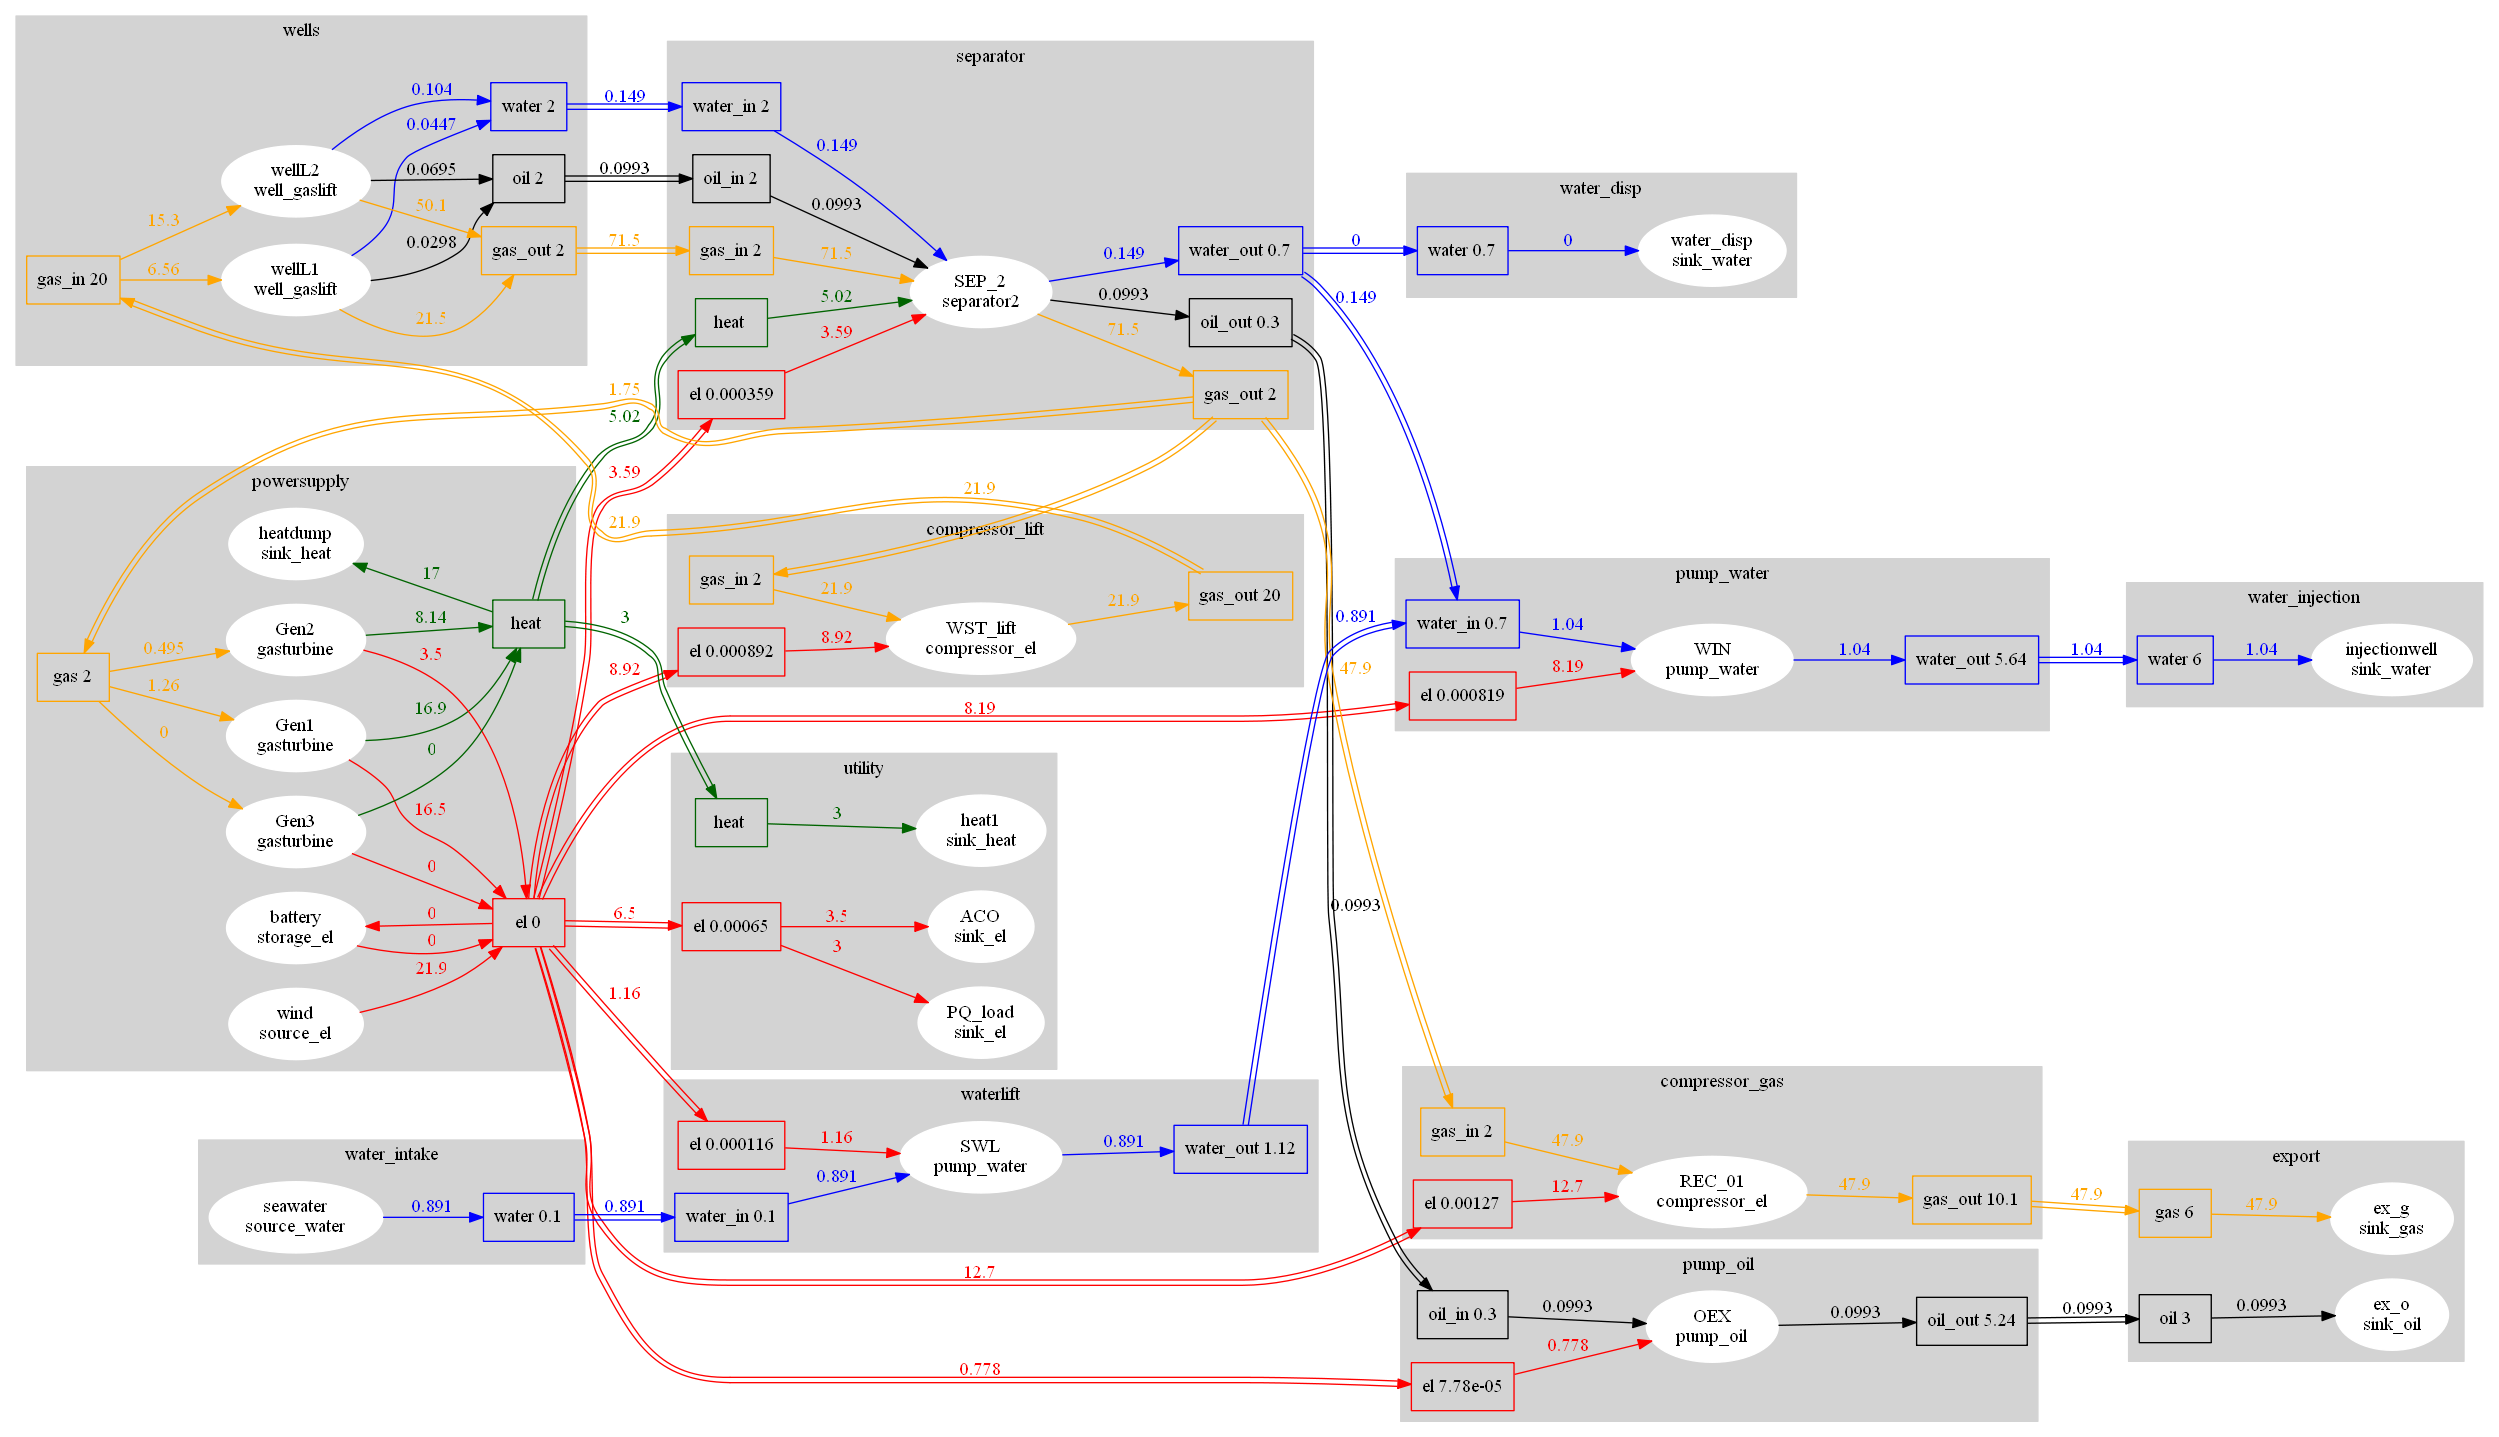

In [284]:
#tstep=10#2*24*60/5-5
tstep=323
gCombined = plots.plotNetwork(mc,timestep=tstep,numberformat="{:.3g}",
    filename=outpath+"network_combined.png")
for carr in []:
#for carr in ['el','heat','gas','oil','wellstream','water']:
    plots.plotNetwork(mc,timestep=tstep,only_carrier=[carr],
        filename=outpath+"network_{}_{}.png".format(carr,tstep))
#gCombined=plots.plotNetwork(mc,timestep=tstep,only_carrier='el',rankdir='TB')
#gHeat = plots.plotNetwork(mc,timestep=tstep,only_carrier='heat')
#gGas = plots.plotNetwork(mc,timestep=tstep,only_carrier='gas')
#gOil = plots.plotNetwork(mc,timestep=tstep,only_carrier='oil')
#gWater = plots.plotNetwork(mc,timestep=tstep,only_carrier='water')
IPython.display.Image(gCombined.create_png())

Notes to figure:
* Electrical power going into separator - Is this already included in the gas re-compression?
* Oil export pump power demand turns out very small (0.3 MW) for flow 0.1 Sm3/s and pressure increase from 0.3 to 3 MPa - is this realistic?
* Why is water injection higher than minimum value? (limiting gives infeasible solution - eiteher Q must be allowed higher, or pressure must be allowed to deviate - but why?)

In [484]:
#mc.instance.paramCarriers.pprint()
#mc.instance.paramEdge['w3']
#mc.instance.paramEdge['w3']['diameter_mm']=200

In [485]:
print("CHECKING edge pressure drop")
#mc.computeEdgePressureDrop(tstep)
print('c2:',mc.compute_edge_pressuredrop(mc.instance,edge='c2',Q=50/15,p1=10,linear=False))
print('w1:',mc.compute_edge_pressuredrop(mc.instance,edge='w1',Q=1.15,p1=0.7,linear=True))
print('w3:',mc.compute_edge_pressuredrop(mc.instance,edge='w3',Q=1.3/15,p1=7,linear=False))
print('o2:',mc.compute_edge_pressuredrop(mc.instance,edge='o2',Q=0.1,p1=5,linear=True))
print('g2:',mc.compute_edge_pressuredrop(mc.instance,edge='g2',Q=48,p1=10,linear=True))
mc.checkEdgePressureDrop(timestep=1,var="outer")

CHECKING edge pressure drop
c2: 7.839392263020411
w1: 0.10778194195115598
w3: 6.117756712984327
o2: 2.7294247394969373
g2: 5.889546177373956
wellstream edge c1:wells-transport (Q=50.0 m3/s)
	NOMINAL:    pin=6.0  pout=6.0  pout_computed=-42.487 pout_linear=  6
	SIMULATION: pin=6.0  pout=6.0  pout_computed=-42.487 pout_linear=  6
	flow velocity = 1591.5 m/s
wellstream edge c2:transport-separator (Q=50.0 m3/s)
	NOMINAL:    pin=6.164  pout=4.0  pout_computed=4.0034 pout_linear=4.0034
	SIMULATION: pin=6.1606064  pout=4.0  pout_computed=  4 pout_linear=  4
	flow velocity = 106.1 m/s
oil edge o1:separator-pump_oil (Q=0.1 m3/s)
	NOMINAL:    pin=0.3  pout=0.3  pout_computed=0.29595 pout_linear=0.3
	SIMULATION: pin=0.3  pout=0.3  pout_computed=0.29595 pout_linear=0.3
	flow velocity = 3.1831 m/s
oil edge o2:pump_oil-export (Q=0.1 m3/s)
	NOMINAL:    pin=5.0  pout=3.0  pout_computed=2.9755 pout_linear=2.7294
	SIMULATION: pin=5.2705753  pout=3.0  pout_computed=3.2461 pout_linear=  3
	flow velocity =

Notes to the above computed edge flows:  
* velocity of wellstream transport is very high.But it is not an incompressible liquid, so the density is not fixed (should be higher as the pressure is high)
    * compressibility $\rho = \rho_b\exp[c(p-p_b)]$; $p_b,\rho_b$ is pressure and density at XX. $c$ is the compressibility
    * " Density of reservoir oil varies from 30 lbm/ft3 for light volatile oils to 60 lbm/ft3 for heavy crudes with little or no solution gas. (480-961 kg/m3) 
    * "Oil compressibility may range from 3e6 psi^-1 for heavy crude oils to 50e6 psi^-1 for light oils. " (1 psi = 6894.76 Pa) => c = 438/Pa - 7251/Pa
    * p_b=0.1 MPa, rho_b=5.6 kg/m3 (cf above), c=6000/Pa, p=6 MPa => rho=OVERFLOW ERROR
* pressure drop for oil pipelines is very large 14 MPa/5km / 0.03 MPa/0.1km - and flow velocity (13 m/s) is probably too high **--improved by using 200mm instead of 100mm pipes: 3.1 m/s and 0.5 MPa/5km, 0.001MPa/0.1km**
* Clearly ERROR in wellstream and water pipe pressure drop computations => multiple parallel pipes fixes

In [459]:
50/6894.76,5.6*np.exp(6e-6*(6-0.1)*1e6)

(0.007251884039473455, 1.3249902618133818e+16)

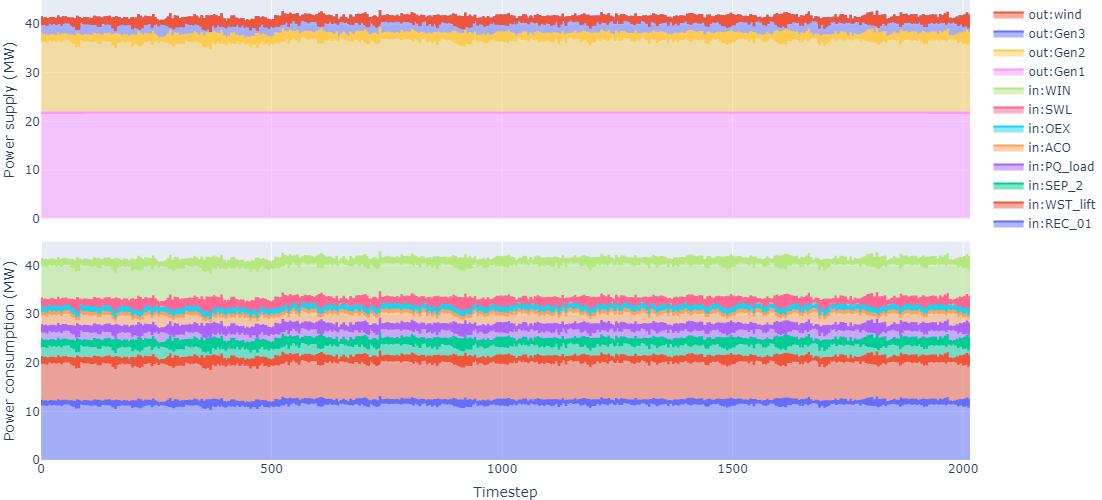

In [529]:
#plots.plot_SumPowerMix(mc,carrier="el",filename=outpath+"el_sum_opt.png")
plots.plotter='plotly'
#fig=plots.plot_SumPowerMix(mc_1a,carrier="el",filename=None)
#plots.plotter='matplotlib'
fig2=plots.plot_SumPowerMix(mc,carrier="el",filename=None)
fig2.update_layout(autosize=False,width=800,height=500,margin=dict(l=0,r=0,t=0,b=0))
#fig2.write_image("{}/elpowermix_{}.png".format(outpath,case))

In [7]:
#fig=plots.plot_SumPowerMix(mc,carrier="gas",filename=None)

<AxesSubplot:ylabel='device'>

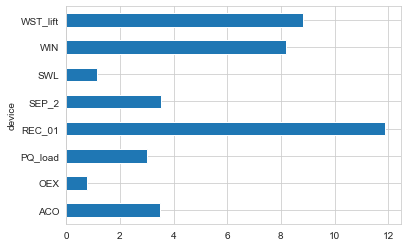

In [65]:
mean_el_demand = mc._dfDeviceFlow.unstack('carrier')['el'].unstack('terminal')['in'].dropna().unstack().T.mean()
mean_el_demand.plot.barh()

<AxesSubplot:ylabel='device'>

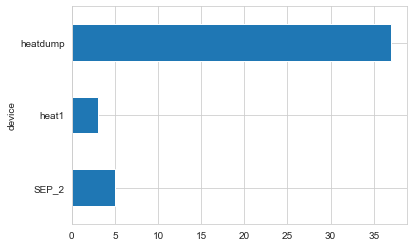

In [66]:
mean_heat_demand = mc._dfDeviceFlow.unstack('carrier')['heat'].unstack('terminal')['in'].dropna().unstack().T.mean()
mean_heat_demand.plot.barh()

In [79]:
mean_el_demand,mean_heat_demand

(device
 ACO          3.500000
 OEX          0.769108
 PQ_load      3.000000
 REC_01      11.879719
 SEP_2        3.546895
 SWL          1.160541
 WIN          8.190000
 WST_lift     8.814584
 dtype: float64,
 device
 SEP_2        4.965654
 heat1        3.000000
 heatdump    36.968979
 dtype: float64)

In [166]:
mc._dfDeviceFlow.unstack('carrier')['gas'].unstack('terminal')['out'].dropna().unstack().T.mean()

device
REC_01      45.219313
SEP_2       70.354530
WST_lift    21.497217
wellL1      21.106359
wellL2      49.248171
dtype: float64

In [165]:
well_inout=mc._dfDeviceFlow.unstack('device')[['wellL1','wellL2']].sum(axis=1).unstack('time').mean(axis=1).unstack('terminal')
(well_inout['out']-well_inout['in']).sum()

49.10159905628473

In [106]:
# Check DUALS ()

import pyomo.environ as pyo
# display all duals
for c in instance.component_objects(pyo.Constraint, active=True):
    if len(c)>0:
        print ("   Constraint",c, (len(c)))
        ci=list(c)[0:6]
        for index in ci:
            thedual=instance.dual[c[index]]
            if thedual!=0:
                print ("      ", index, thedual)

   Constraint constrDevice_well_gaslift 384
       ('wellL1', 'oil', 0, 2) -17.307947
       ('wellL1', 'oil', 1, 2) -17.307947
       ('wellL1', 'oil', 2, 2) -17.307947
   Constraint constrDevice_separator2 192
       ('SEP_2', 'oil', 0, 1) -17.448712
       ('SEP_2', 'oil', 0, 3) 0.0012282313
       ('SEP_2', 'oil', 1, 1) -17.448712
   Constraint constrDevice_compressor_el 96
       ('REC_01', 0, 1) 0.016988288
       ('REC_01', 0, 2) 0.0012282313
       ('REC_01', 1, 1) 0.016988288
       ('REC_01', 1, 2) 0.0012282313
       ('REC_01', 2, 1) 0.016988288
       ('REC_01', 2, 2) 0.0012282313
   Constraint constrDevice_gasturbine 144
       ('Gen1', 0, 1) 0.014621801
       ('Gen1', 1, 1) 0.014621801
       ('Gen1', 2, 1) 0.014621801
   Constraint constrDevice_source_water 24
   Constraint constrDevice_pump_oil 48
       ('OEX', 0, 1) -17.458333
       ('OEX', 0, 2) 0.0012282313
       ('OEX', 1, 1) -17.458333
       ('OEX', 1, 2) 0.0012282313
       ('OEX', 2, 1) -17.458333
       ('O

In [353]:
mc._dfExportRevenue.index

Int64Index([556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568,
            569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581,
            582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594,
            595, 596, 597],
           dtype='int64')

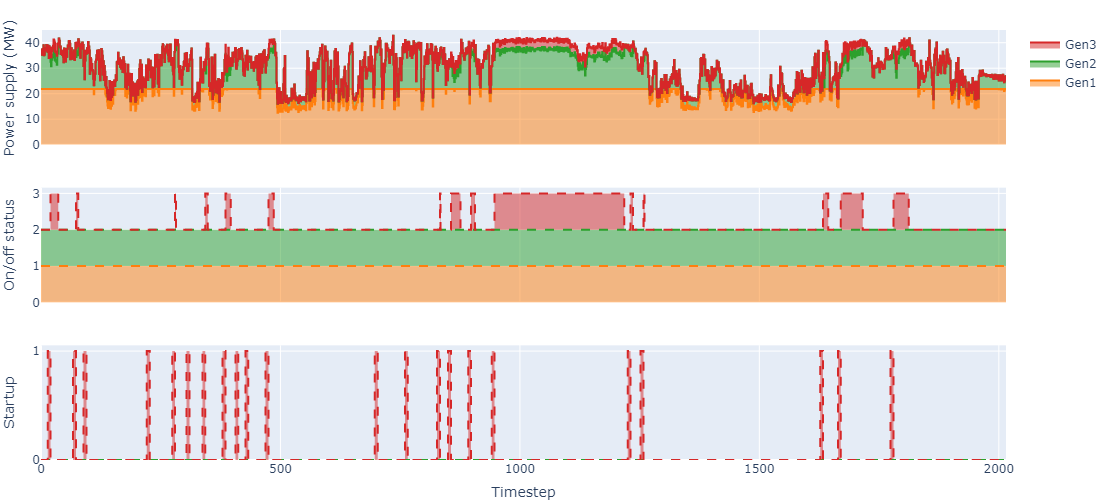

In [515]:
plots.plotter="plotly"
gts = [d for d in mc.instance.setDevice 
       if mc.instance.paramDevice[d]['model']=='gasturbine']
#plots.plot_deviceprofile(mc,devs=gts,profiles=profiles,filename=outpath+"GTs_opt.png")
fig=plots.plot_deviceprofile(mc,devs=gts,filename=None,includeOnOff=True,includePrep=True)
fig.update_layout(autosize=False,width=800,height=500,margin=dict(l=0,r=0,t=30,b=0))

In [174]:
#mc._dfDeviceStarting.unstack('device').loc[310:,['Gen1','Gen2','Gen3']].plot()
#mc._dfDeviceStopping.unstack('device').loc[310:,['Gen1','Gen2','Gen3']].plot()

In [236]:
gt='Gen3'
dfStart=pd.concat([
    mc._dfDeviceStarting[gt],
    mc._dfDeviceIsPrep[gt],
    mc._dfDeviceIsOn[gt],
    mc._dfDeviceStopping[gt]],axis=1)
dfStart.columns=['starting','prep','on','stopping']
dfStart.loc[80:100]

starting  prep   on  stopping
time                               
80         0.0   0.0  0.0       0.0
81         0.0   0.0  0.0       0.0
82         0.0   0.0  0.0       0.0
83         0.0   0.0  0.0       0.0
84         0.0   0.0  0.0       0.0
85         0.0   0.0  0.0       0.0
86         0.0   0.0  0.0       0.0
87         0.0   0.0  0.0       0.0
88         0.0   0.0  0.0       0.0
89         1.0   1.0  0.0       0.0
90         0.0   1.0  0.0       0.0
91         0.0   1.0  0.0       0.0
92         0.0   1.0  0.0       0.0
93         0.0   1.0  0.0       0.0
94         0.0   1.0  0.0       0.0
95         0.0   0.0  0.0       1.0
96         0.0   0.0  0.0       0.0
97         0.0   0.0  0.0       0.0
98         0.0   0.0  0.0       0.0
99         0.0   0.0  0.0       0.0
100        0.0   0.0  0.0       0.0

In [180]:
gt='Gen2'
print(pyo.value(mc.instance.paramDeviceIsOnInitially[gt]))
print(pyo.value(mc.instance.paramDevicePrepTimestepsInitially[gt]))
for t in range(8):
    cstr=mc.instance.constrDevice_startup_shutdown[gt,t]
    print(t,cstr.body,"=",cstr.upper)
for t in range(8):
    cstr=mc.instance.constrDevice_startup_delay[gt,t]
    print(t,cstr.body,"=",cstr.upper)
for t in range(8):
    cstr=mc.instance.constrDevicePmax[gt,t]
    print(t,cstr.body,"=",cstr.upper)

1.0
0
0 varDeviceIsOn[Gen2,0] - paramDeviceIsOnInitially[Gen2] + varDeviceStopping[Gen2,0] = 0.0
1 varDeviceIsOn[Gen2,1] - varDeviceIsOn[Gen2,0] + varDeviceStopping[Gen2,1] = 0.0
2 varDeviceIsOn[Gen2,2] - varDeviceIsOn[Gen2,1] + varDeviceStopping[Gen2,2] = 0.0
3 varDeviceIsOn[Gen2,3] - varDeviceIsOn[Gen2,2] + varDeviceStopping[Gen2,3] = 0.0
4 varDeviceIsOn[Gen2,4] - varDeviceIsOn[Gen2,3] + varDeviceStopping[Gen2,4] = 0.0
5 varDeviceIsOn[Gen2,5] - varDeviceIsOn[Gen2,4] + varDeviceStopping[Gen2,5] = 0.0
6 varDeviceIsOn[Gen2,6] - varDeviceIsOn[Gen2,5] - (varDeviceStarting[Gen2,0] - varDeviceStopping[Gen2,6]) = 0.0
7 varDeviceIsOn[Gen2,7] - varDeviceIsOn[Gen2,6] - (varDeviceStarting[Gen2,1] - varDeviceStopping[Gen2,7]) = 0.0
0 varDeviceIsPrep[Gen2,0] - varDeviceStarting[Gen2,0] = 0.0
1 varDeviceIsPrep[Gen2,1] - (varDeviceStarting[Gen2,1] + varDeviceStarting[Gen2,0]) = 0.0
2 varDeviceIsPrep[Gen2,2] - (varDeviceStarting[Gen2,2] + varDeviceStarting[Gen2,1] + varDeviceStarting[Gen2,0]) = 0.0
3

In [420]:
dfStartopt = pd.DataFrame()
for t in mc.instance.setHorizon: 
    dfStartopt.loc[t,'start']=mc.instance.varDeviceStarting['Gen2',t].value
    dfStartopt.loc[t,'prep']=mc.instance.varDeviceIsPrep['Gen2',t].value
    dfStartopt.loc[t,'on']=mc.instance.varDeviceIsOn['Gen2',t].value
    dfStartopt.loc[t,'stop']=mc.instance.varDeviceStopping['Gen2',t].value
#dfStartopt

In [461]:
dfRes = pd.DataFrame()
for t in mc.instance.setHorizon: 
    dfRes.loc[t,'storE']=mc.instance.varDeviceStorageEnergy['battery',t].value
    dfRes.loc[t,'storPmax']=mc.instance.varDeviceStoragePmax['battery',t].value
    dfRes.loc[t,'reserve'] = pyo.value(mc.compute_elReserve(mc.instance,t))
dfRes

storE  storPmax    reserve
0     4.0       4.0   7.892517
1     4.0       4.0   5.931671
2     4.0       4.0   6.825522
3     4.0       4.0   9.399162
4     4.0       4.0   9.065832
5     4.0       4.0  11.984663
6     4.0       4.0  12.179199
7     4.0       4.0  12.244983
8     4.0       4.0  12.643664
9     4.0       4.0  11.512158
10    4.0       4.0  11.179699
11    4.0       4.0  10.301120
12    4.0       4.0  10.282144
13    4.0       4.0  11.272115
14    4.0       4.0  10.786553
15    4.0       4.0  10.967800
16    4.0       4.0  10.526235
17    4.0       4.0  10.348936
18    4.0       4.0  11.026536
19    4.0       4.0  11.292704
20    4.0       4.0  11.116444
21    4.0       4.0  11.049606
22    4.0       4.0  10.249881
23    4.0       4.0  10.332656

In [134]:
for x in range(0,1): print(x)

0


In [31]:
plots.plotter='plotly'
#plots.plotter='matplotlib'

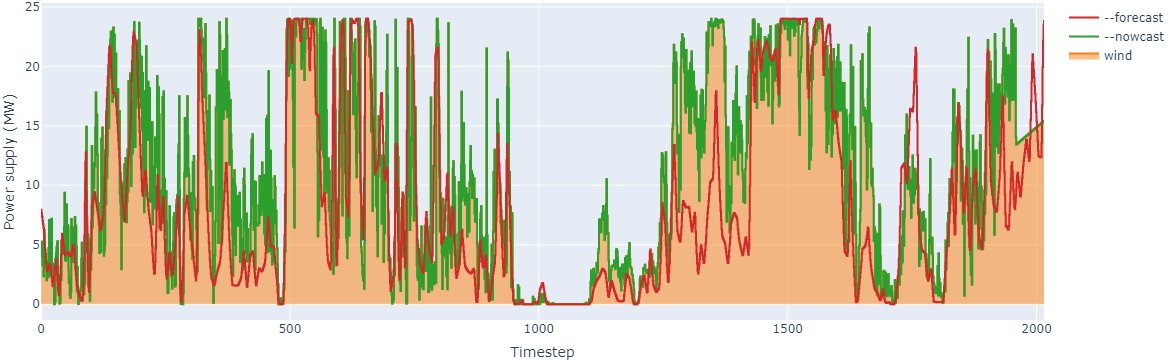

In [228]:
fig=plots.plot_deviceprofile(mc,devs=['wind'],filename=None,includeForecasts=True)
fig.update_layout(autosize=False,width=800,height=300,margin=dict(l=0,r=0,t=0,b=0))

In [492]:
#df.dropna(how='all')
#mc._dfDeviceFlow.unstack([0,1,2]).columns
#mc._dfDeviceFlow.unstack([0,1,2])[[('ex_g','gas','in'),('ex_o','oil','in')]]
#mc._dfDeviceFlow.unstack([1,2])[('el','out')].unstack(0)

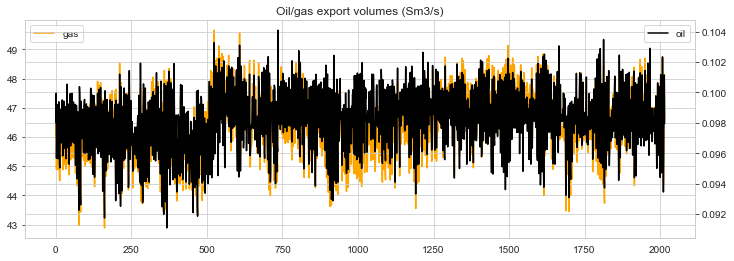

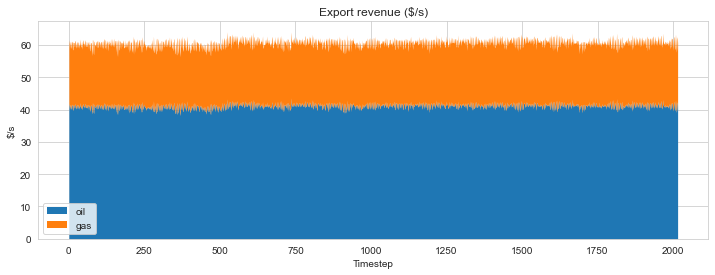

In [184]:
plt.figure(figsize=(12,4))
ax=plt.gca()
labels=[]
#df=mc._dfDevicePower.unstack(0)[['ex_g','ex_o']]
df=mc._dfDeviceFlow.unstack([0,1,2])[[('ex_g','gas','in'),('ex_o','oil','in')]]
ax.plot(df['ex_g'],label='gas',color='orange')
ax.legend(loc='upper left')
ax2=ax.twinx()
ax2.plot(df['ex_o'],label='oil',color='black')
ax2.legend(loc='upper right')
plt.title("Oil/gas export volumes (Sm3/s)")

#    ax.legend(labels,loc='lower left', bbox_to_anchor =(1.01,0),
#              frameon=False)
#plt.savefig(outpath+"export.png",bbox_inches = 'tight')

plots.plot_ExportRevenue(mc)

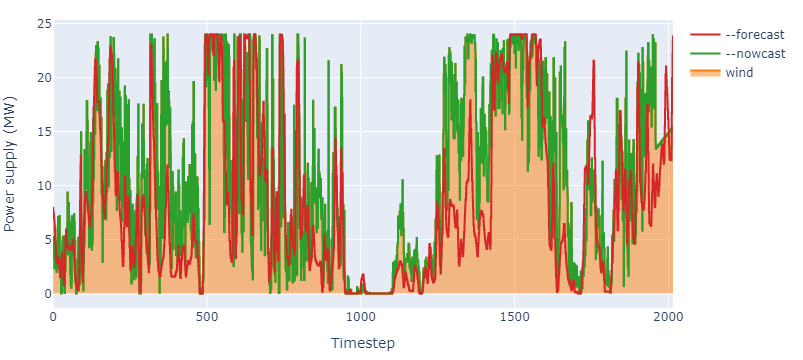

In [498]:
plots.plotter="plotly"
fig=plots.plot_deviceprofile(mc,devs=['wind'],includeForecasts=True,includeOnOff=False,
                             filename=None)#outpath+"WT_opt.png")
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),width=800,height=300)
fig.show()

In [394]:
#mc._dfDeviceFlow['battery']
#mc._dfDeviceFlow['battery','el'].unstack('terminal')
#pd.DataFrame(mc._dfDeviceStorageEnergy['battery'])

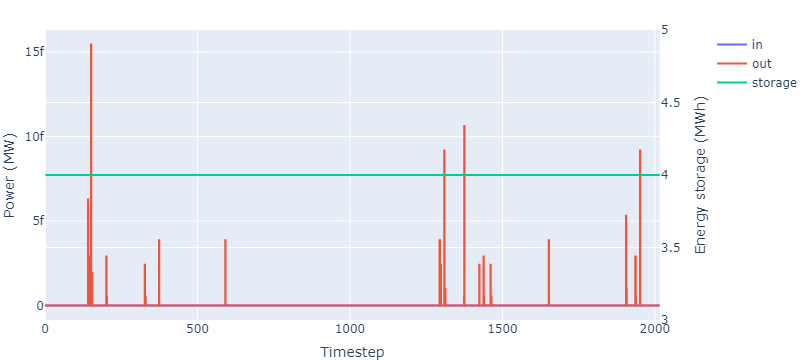

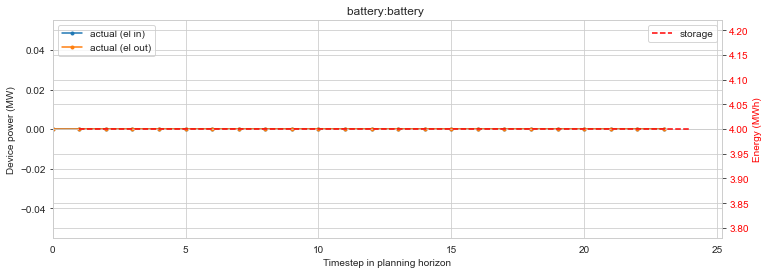

In [499]:
plots.plotter="plotly"
if 'battery' in mc.instance.setDevice:
    fig=plots.plot_devicePowerEnergy(mc,'battery',
                                 filename=None)#outpath+"battery_opt.png")
    fig.update_layout(autosize=False,width=800,height=300,margin=dict(l=0,r=0,t=30,b=0)).show()
    multicarrier.Plots.plotDevicePowerLastOptimisation1(mc,device='battery',
                filename=None)#outpath+"lastopt_battery.png")

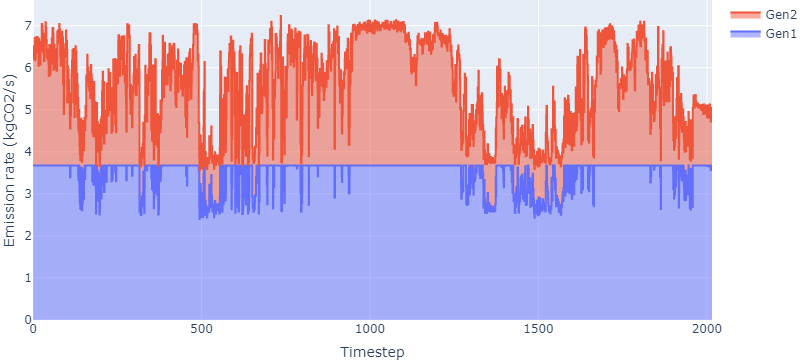

In [500]:
plots.plotter="plotly"
fig=plots.plot_CO2rate_per_dev(mc,reverseLegend=True,filename=outpath+"co2rate_opt.png")
fig.update_layout(autosize=False,width=800,height=300,margin=dict(l=0,r=0,t=0,b=0))

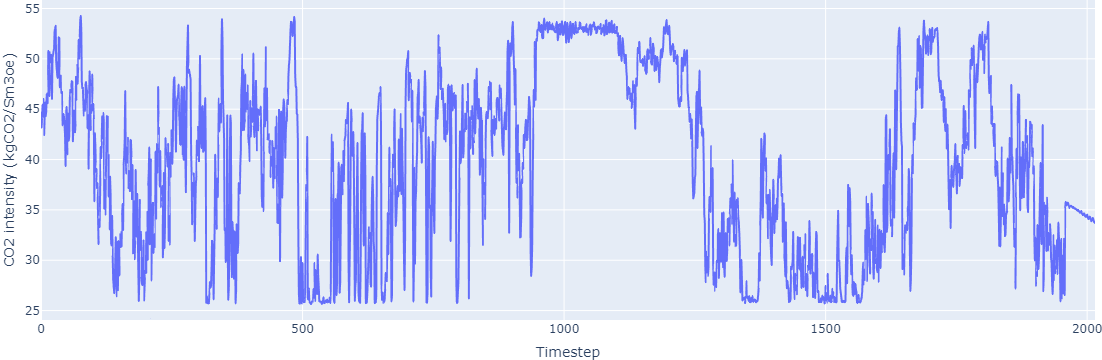

In [263]:
#plots.plot_CO2rate(mc_1a)#,filename=outpath+"co2rate_opt.png")
fig=plots.plot_CO2_intensity(mc_1a,filename=outpath+"co2intensity_opt.png")
fig.update_layout(autosize=False,width=700,height=300,margin=dict(l=0,r=0,t=0,b=0))
#p=plots.plot_df(mc._dfDevicePower,id_var="device",filename=None,#outpath+"plotly.html",
#              title="Device Power",ylabel="Power (MW)")
#df_long=mc._dfDeviceFlow#.reset_index().rename(columns={0:'value'})
#p=plots.plot_df(df_long,id_var="device",filename=None,#outpath+"plotly.html",
#              title="Device energy/fluid flow",ylabel="(MW or Sm3/s)")


# Last optimisisation (results for a horizon)
#multicarrier.Plots.plotDeviceSumPowerLastOptimisation(instance,
#                                                      filename=outpath+"lastopt_devsum_el.png")
#multicarrier.Plots.plotEmissionRateLastOptimisation(instance,filename=outpath+"lastopt_co2out.png")


Reserve capacity
For each power supply unit:
* shows power output (dotted line)
* shows reserve capacity (solid line) - available unused power by other generators and loads that can be shed

MARGIN = minimal value of the difference between reserve and output for each generator at each timestep
* margin = min_i (reserve_i-poweroutput_i)

5


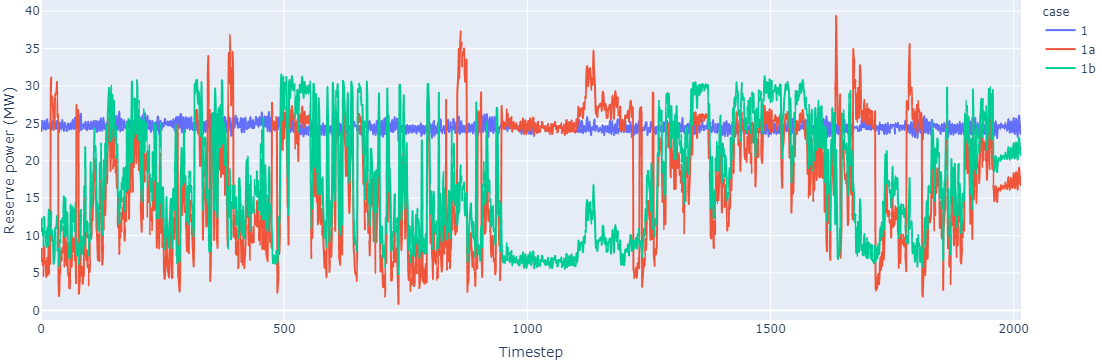

In [544]:
#mc.compute_elReserve(mc.instance,exclude_device='Gen1',t=10))
print(mc.instance.paramParameters['elReserveMargin'])
#print(mc.compute_elReserve(mc.instance,3))
#batt=mc_1b._dfDeviceStorageEnergy.unstack('device')['battery']
#batt_mc=mc._dfDeviceStorageEnergy.unstack('device')['battery']
dfplot=pd.concat([mc_1._dfElReserve,mc_1a._dfElReserve,mc_1b._dfElReserve],axis=1)
dfplot.columns=['1','1a','1b']
dfplot.columns.name='case'
fig=px.line(dfplot,title="Reserve",labels={'x':'Power (MW)','y':'Timestep'})
fig.update_xaxes(title_text="Timestep")
fig.update_yaxes(title_text="Reserve power (MW)",dtick = 5)
fig.update_layout(autosize=False,width=800,height=300,margin=dict(l=0,r=0,t=0,b=0))
fig.show()

In [354]:
#mc.instance.varDeviceStoragePmax.pprint()
#mc.instance.varDeviceStorageEnergy.pprint()
#mc.instance.constrDevice_storage_el.pprint()

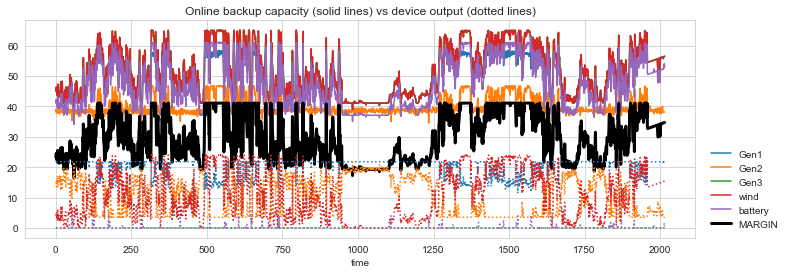

In [355]:
dfm=plots.plotElBackup(mc,showMargin=True,returnMargin=True)

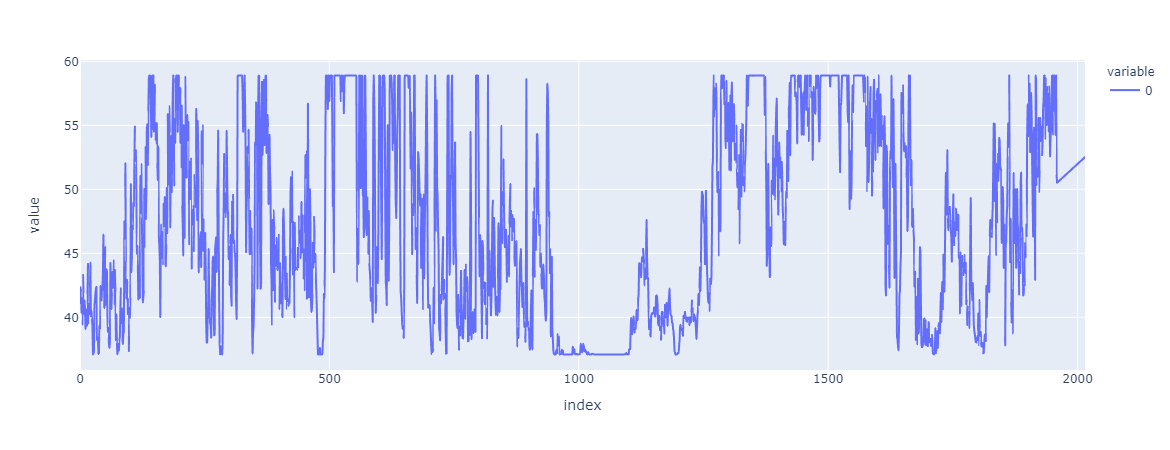

In [291]:
px.line(dfm)